In [1]:
from ase.io import read,write
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN


def add_allegro_number_array(ase_atom: Atoms, eps: float = .75, min_samples: int = 1) -> np.ndarray:
    """
    Assigns a number from 0 to 5 to each atom depending on its layer and position using DBSCAN clustering algorithm.

    :param ase_atom: ASE Atoms object with atom positions.
    :param eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    :param min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    :return: A numpy array with assigned cluster numbers for each atom.
    """
    z_coords = ase_atom.positions[:, 2].reshape(-1, 1)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(z_coords)
    labels = db.labels_

    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels >= 0]

    mean_positions = [z_coords[labels == label].mean() for label in unique_labels]
    sorted_indices = np.argsort(mean_positions)



    label_mapping = np.array([1, 2, 0, 4, 5, 3])
    # print(labels[:6],sorted_indices,sorted_indices[label_mapping])

    allegro_number_array = np.array([sorted_indices[label_mapping][label] if label != -1 else -1 for label in labels])

    return allegro_number_array

In [5]:
def rotate_to_x_axis(atoms):
    # Vector representing the x-axis
    x_axis = np.array([1, 0, 0])
    
    # The first lattice vector
    lattice_vector = atoms.cell[0]
    
    # Normalize the lattice vector
    norm_lattice_vector = lattice_vector / np.linalg.norm(lattice_vector)
    
    # Calculate the axis of rotation (cross product of x_axis and lattice_vector)
    rotation_axis = np.cross(x_axis, norm_lattice_vector)
    
    # Calculate the cosine of the angle between norm_lattice_vector and x_axis
    cos_angle = np.dot(x_axis, norm_lattice_vector)
    
    # Calculate the angle in degrees
    angle = np.arccos(cos_angle) * 180 / np.pi
    
    # Rotate the atoms and cell if the rotation axis is not zero vector
    if np.linalg.norm(rotation_axis) > 0:
        # Rotating both the atoms and the cell
        atoms.rotate(v=rotation_axis, a=-angle, center=(0,0,0), rotate_cell=True)

    return atoms

structures = read("./mos2_interlayer_dset.xyz",index=":")
numbers_list = np.array([0,1,2,0,1,2,3,4,5,3,4,5])

# for s in structures:
#     s.arrays['atom_types'] = numbers_list[s.arrays['atom_types']]

# moire = read("591-6.01_deg-546_atoms.xsf",format="xsf")
# moire = read("relax.out",index = -1,format="espresso-out")
moire = read("MoS2-2deg-relax.xsf",format="xsf")
moire.arrays['atom_types'] = add_allegro_number_array(moire)
# write("test.cif", moire, format="cif")

# moire = rotate_to_x_axis(moire)

structures[0].info


{'energy': 4.24654135394303,
 'il_dist': 2.1000000000000014,
 'lateral_dist_x': 0.0,
 'lateral_dist_y': 0.0,
 'cbm': 0.3163999999999998,
 'vbm': -0.0029000000000003467,
 'efermi': 2.3812,
 'bandgap': 0.31930000000000014,
 'bandgap_rel': -1.4975999999999998,
 'lj_energy': 0}

In [12]:
structures[0].get_total_energy()

4.24654135394303

In [6]:
import pymoire as pm

def prepare_database(structures,pristine_atoms):

    pristine_cell = pristine_atoms.cell
    pristine_cell[2,2] = 100
    numbers_list = np.array([0,1,2,0,1,2,3,4,5,3,4,5])


    clean_database = []
    # unique_atom_types = np.unique(structures[0].arrays['atom_types'])
    for ss in structures:
        s = ss
        del s[[3,4,5,9,10,11]]
        s.positions -= s.positions[np.where(s.arrays['atom_types'] == 0)[0][0]]
        s.arrays['atom_types'] = np.array([0,1,2,3,4,5],dtype=int)
        # s.set_cell(pristine_cell)
        clean_database.append(s)
        # scaled_positions = s.get_scaled_positions()

    return clean_database

# def build_database_fingerprint(db):
#     db_fingerprint = []
#     for s in db:
#         positions = s.positions
#         scaled_positions = s.get_scaled_positions()
#         scaled_positions = (((scaled_positions + 0.5) % 1) - 0.5)
#         fingerprint = np.linalg.norm(positions[:,None] - positions[None,:],axis = -1)
#         fingerprint_scaled = np.linalg.norm(scaled_positions[:,None] - scaled_positions[None,:],axis = -1)
        
#         db_fingerprint.append({"fp": fingerprint,
#                                'fp_scaled':fingerprint_scaled,
#                                'scaled_positions':scaled_positions,
#                                'il_dist': s.info['il_dist'],
#                                'e_value': s.info['bandgap_rel']})
#     return db_fingerprint

# def build_database_2Dfingerprint(db):
#     db_fingerprint = []
#     for s in db:
#         positions = s.positions
#         scaled_positions = s.get_scaled_positions()
#         scaled_positions = (((scaled_positions + 0.5) % 1) - 0.5)
#         fingerprint = np.linalg.norm(positions[:,None,:2] - positions[None,:,:2],axis = -1)
#         fingerprint_scaled = np.linalg.norm(scaled_positions[:,None,:2] - scaled_positions[None,:,:2],axis = -1)
        
#         db_fingerprint.append({"fp": fingerprint,
#                                'fp_scaled':fingerprint_scaled,
#                                'scaled_positions':scaled_positions,
#                                'il_dist': s.info['il_dist'],
#                                'e_value': s.info['bandgap_rel']})
#     return db_fingerprint


p = pm.materials.get_materials_db_path()
pristine_atoms = pm.read_monolayer(p/'MoS2.cif')

clean_database = prepare_database(structures,pristine_atoms)
clean_database[0].positions

# db_fingerprint = build_database_fingerprint(clean_database)
# db_2Dfingerprint = build_database_2Dfingerprint(clean_database)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.81630283,  1.57172298],
       [ 0.        ,  1.81630283, -1.57172298],
       [ 0.        ,  0.        ,  5.24344596],
       [ 0.        ,  1.81630283,  6.81516894],
       [ 0.        ,  1.81630283,  3.67172298]])

In [19]:
clean_database[0].arrays

{'numbers': array([42, 16, 16, 42, 16, 16]),
 'positions': array([[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.81630283,  1.57172298],
        [ 0.        ,  1.81630283, -1.57172298],
        [ 0.        ,  0.        ,  5.24344596],
        [ 0.        ,  1.81630283,  6.81516894],
        [ 0.        ,  1.81630283,  3.67172298]]),
 'forces': array([[ 5.21900000e-05, -3.22262000e-03, -6.30810900e-01],
        [ 1.10600000e-05,  2.44692000e-03, -3.97030059e+00],
        [ 2.57000000e-06,  6.52030000e-04, -2.37162160e-01],
        [ 5.29600000e-05, -3.13058000e-03,  6.30741740e-01],
        [ 6.17000000e-06,  6.11410000e-04,  2.37223090e-01],
        [ 1.08000000e-05,  2.46337000e-03,  3.97033864e+00]]),
 'atom_types': array([0, 1, 2, 3, 4, 5])}

Cell([[90.44562676952948, 0.0, 0.0], [-45.22281338476475, 78.32821044361843, 0.0], [0.0, 0.0, 21.3325566973398]])


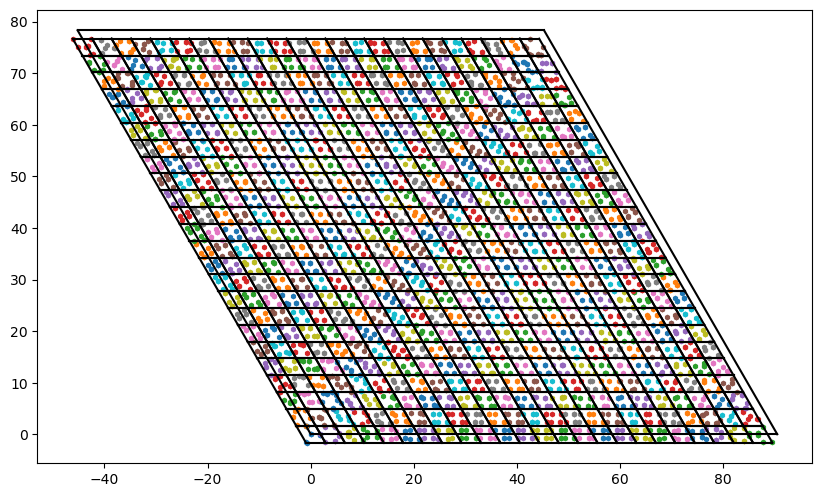

In [9]:
def create_grid(moire_atoms, n):
    """
    Subdivides a moiré structure into an n x n grid of atom objects.

    Parameters:
    - moire_atoms: The atoms object representing the moiré structure.
    - n: The number of subdivisions along one axis.

    Returns:
    - grid: A 2D array representing the grid points.
    - moire_grid_atoms: A 2D array of atoms objects for each grid cell.
    """
    # Store the original moiré cell
    original_cell = moire_atoms.cell
    
    # Repeat the atoms to ensure full coverage for edge cases
    moire_atoms = moire_atoms.repeat((3, 3, 1))
    
    # Restore the original cell size to keep physical dimensions consistent
    moire_atoms.set_cell(original_cell)
    
    # Calculate the shift needed for moiré pattern
    moire_shift = moire_atoms.cell[0] + moire_atoms.cell[1]
    moire_atoms.positions[:, :2] -= moire_shift[:2]

    # Create grid points within the moiré cell
    x = (np.linspace(0, 1, n + 1) - 1 / (2 * n))[:, None] * moire_atoms.cell[0]
    y = (np.linspace(0, 1, n + 1) - 1 / (2 * n))[:, None] * moire_atoms.cell[1]

    # Define the size of each grid cell
    grid_cell = moire_atoms.cell / np.array([n, n, 1])

    # Combine x and y to form a 2D grid
    grid = x[:, None, :2] + y[None, :, :2]
    
    # Transform the grid points to the moiré coordinates
    moire_grid = grid @ np.linalg.inv(grid_cell[:2, :2])

    # Initialize a list to hold the atoms objects for each grid cell
    moire_grid_atoms = []

    # Count the unique types of atoms in the moiré structure
    n_unique_atom_types = len(np.unique(moire_atoms.arrays['atom_types']))

    # Iterate over the grid to populate it with atoms objects
    for i in range(n):
        grid_atoms_row = []
        for j in range(n):
            # Copy the moiré atoms to manipulate them for each grid cell
            m_ij = moire_atoms.copy()
            
            # Define the corners of the current grid cell in moiré coordinates
            x0y0 = moire_grid[i, j]
            x1y1 = moire_grid[i + 1, j + 1]
            
            # Get the positions of atoms in the current moiré atoms object
            m_ij_pos = m_ij.get_positions()
            m_ij_pos_scaled = m_ij_pos[:, :2] @ np.linalg.inv(grid_cell[:2, :2])

            # Filter atoms to include only those within the current grid cell
            m_ij = m_ij[np.logical_and(m_ij_pos_scaled[:, 0] < x1y1[0],
                                       m_ij_pos_scaled[:, 0] > x0y0[0])]

            # Update positions after filtering
            m_ij_pos_scaled = m_ij_pos_scaled[np.logical_and(m_ij_pos_scaled[:, 0] < x1y1[0],
                                                             m_ij_pos_scaled[:, 0] > x0y0[0])]

            # Repeat filtering for the y dimension
            m_ij = m_ij[np.logical_and(m_ij_pos_scaled[:, 1] < x1y1[1],
                                       m_ij_pos_scaled[:, 1] > x0y0[1])]

            # Check if the filtered atoms contain all unique atom types
            if len(np.unique(m_ij.arrays['atom_types'])) != n_unique_atom_types:
                print(f"WARNING: Grid cell ({i}, {j}) contains {len(np.unique(m_ij.arrays['atom_types']))} unique atom types")
                return None

            # Append the filtered atoms object to the current row
            grid_atoms_row.append(m_ij)
        
        # Append the current row to the moire_grid_atoms
        moire_grid_atoms.append(grid_atoms_row)
    
    return grid, moire_grid_atoms

def plot_moire_grid(moire, moire_grid, moire_grid_atoms):
    n_rows = len(moire_grid_atoms) + 1
    plt.figure(figsize=(10,10))
    # plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
    offsets = np.array([(i, j) for i in [-1, 0, 1] for j in [-1, 0, 1]]) @ moire.cell[:2,:2]
    offsets = np.array([0,0,0])

    for i in range(n):
        for j in range(n):
            
            m1 = moire_grid_atoms[i][j]
            m1_pos = m1.get_positions()
            metal_cond = np.where(np.logical_or(m1.arrays['atom_types']==0,
                                       m1.arrays['atom_types']==3))[0]
            metal_cond = [True] * len(m1_pos)
            plt.scatter(m1_pos[metal_cond,0][:,None],
                        m1_pos[metal_cond,1][:,None], s = 10, marker = 'h')
            
            # plt.scatter(m1_pos[metal_cond,0],
            #             m1_pos[metal_cond,1], 
            #             s = np.where(m1_pos[metal_cond,2] > m1_pos[metal_cond,2].mean() , 100, 10))
    print(moire.cell)
    for i in range(n_rows-1):
        for j in range(n_rows-1):
            p1 = np.array([moire_grid[i, j,0], moire_grid[i, j,1]])
            p2 = np.array([moire_grid[i+1, j,0], moire_grid[i+1, j,1] ])
            p3 = np.array([moire_grid[i+1, j+1,0], moire_grid[i+1, j+1,1]])
            p4 = np.array([moire_grid[i, j+1,0], moire_grid[i, j+1,1]])
            # print(x0,y0)
            # Draw lines around each grid cell
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
            plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
            plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
            plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

    p1 = np.array([0,0]) @ moire.cell[:2,:2] 
    p2 = np.array([1,0]) @ moire.cell[:2,:2]
    p3 = np.array([1,1]) @ moire.cell[:2,:2]
    p4 = np.array([0,1]) @ moire.cell[:2,:2]
    # print(x0,y0)
    # Draw lines around each grid cell
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
    plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
    plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
    plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge
    

    plt.axis('scaled')
    plt.savefig("moire_grid.png",dpi=300,bbox_inches='tight')
    # plt.xlim(-5,5)
    # plt.ylim(-5,5)

n = 24
moire_grid,moire_grid_atoms = create_grid(moire,n)
plot_moire_grid(moire, moire_grid, moire_grid_atoms)
moire_grid_cell = moire.cell / np.array([n,n,1])

In [8]:
moire_grid.shape

(7, 7, 2)

In [9]:
def get_local_2Dfingerprint(local_structure,moire_grid_cell, k:int  = 12):
    local_structure.cell = moire_grid_cell
    k = len(local_structure)
    zero_atom = local_structure[local_structure.arrays['atom_types'] == 0]
    zero_atom_position = zero_atom[np.argmin(np.linalg.norm(zero_atom.positions[:,:2]))].position
    local_structure.positions[:,:2] -= zero_atom_position[:2]

    local_structure_padded = local_structure.repeat([5,5,1])
    local_structure_shift = local_structure.cell[0] + local_structure.cell[1]
    local_structure_padded.positions -= local_structure_shift * 2

    unique_atom_types = np.unique(local_structure.arrays['atom_types'])
 
    tree = cKDTree(local_structure_padded.positions[:,:2])

    _, ind = tree.query(local_structure.positions[:,:2], k = k)

    xy_diff = local_structure_padded.positions[ind,:2] - local_structure.positions[:,None,:2]
    z_diff = local_structure_padded.positions[ind,2] - local_structure.positions[:,None,2]


    xy_diff_norm = np.linalg.norm(xy_diff,axis = -1)
    z_diff_norm = np.abs(z_diff)

    ntype_dists = np.concatenate((local_structure_padded.arrays['atom_types'][ind][:,:,None],
                                    xy_diff_norm[:,:,None]),
                                    axis = -1)
    ntype_dists = np.take_along_axis(ntype_dists[:,:,:],
                                        np.argsort(ntype_dists[:,:,0],axis = 1)[:,:,None],
                                        axis=1)

    ntype_z_dists = np.concatenate((local_structure_padded.arrays['atom_types'][ind][:,:,None],
                                    z_diff_norm[:,:,None]),
                                    axis = -1)
    ntype_z_dists = np.take_along_axis(ntype_z_dists[:,:,:],
                                        np.argsort(ntype_z_dists[:,:,0],axis = 1)[:,:,None],
                                        axis=1)

    reduced_ntype_dists = [np.split(type[:, 1], np.unique(type[:, 0], return_index=True)[1][1:]) for type in ntype_dists] 
    reduced_ntype_z_dists = [np.split(type[:, 1], np.unique(type[:, 0], return_index=True)[1][1:]) for type in ntype_z_dists] 

    reduced_ntype_fingerprint= [[[np.min(m),np.min(l)]for m,l in zip(type,type_z)] for type, type_z in zip(reduced_ntype_dists,reduced_ntype_z_dists)]
    reduced_ntype_fingerprint= np.concatenate((local_structure.arrays['atom_types'][:,None,None].repeat(len(unique_atom_types),axis = 1),
                                            reduced_ntype_fingerprint),axis = -1).reshape(-1,len(unique_atom_types),3)
    reduced_ntype_fingerprint = np.take_along_axis(reduced_ntype_fingerprint[:,:,:],
                                                np.argsort(reduced_ntype_fingerprint[:,:,0],axis = 0)[:,:,None],
                                                axis=0)

    reduced_nxn_dist_fingerprint = np.split(reduced_ntype_fingerprint[:, :, 1:], np.unique(reduced_ntype_fingerprint[:,0,0], return_index=True)[1][1:])
    reduced_nxn_dist_fingerprint= np.array([np.min(type, axis = 0) for type in reduced_nxn_dist_fingerprint])
    
    return reduced_nxn_dist_fingerprint


def get_db_local_2Dfingerprint(db, pristine_atoms_cell, k:int = 12):
    reduced_nxn_dist_fingerprints = []
    for s in db:
        n_neigbors = k
        s_padded = s.repeat([7,7,1])
        
        s_shift = s.cell[0] + s.cell[1]
        s_padded.positions -= 3*s_shift

        
        unique_atom_types = np.unique(s.arrays['atom_types'])
        
        tree = cKDTree(s_padded.positions[:,:2])
        
#         top_cond = s_padded.positions[:,2] >  s_padded.positions[:,2].mean()
#         bottom_cond = s_padded.positions[:,2] <  s_padded.positions[:,2].mean()
#         metal_cond = np.logical_or(s_padded.arrays['atom_types'] == 0, s_padded.arrays['atom_types'] == 3)

#         chalc_cond = np.logical_not(metal_cond)
#         print(metal_cond,chalc_cond)
#         plt.figure()
#         plt.scatter(s_padded.positions[np.logical_and(bottom_cond,metal_cond),0],s_padded.positions[np.logical_and(bottom_cond,metal_cond),1], marker = 'o', c = 'blue')
#         plt.scatter(s_padded.positions[np.logical_and(bottom_cond,chalc_cond),0],s_padded.positions[np.logical_and(bottom_cond,chalc_cond),1], marker = 'v', c = 'blue')
#         plt.scatter(s_padded.positions[np.logical_and(top_cond,metal_cond),0],s_padded.positions[np.logical_and(top_cond,metal_cond),1],marker = 'h', c = 'orange')
#         plt.scatter(s_padded.positions[np.logical_and(top_cond,chalc_cond),0],s_padded.positions[np.logical_and(top_cond,chalc_cond),1],marker = '^', c = 'orange')
#         plt.axis('scaled')
        including_all_atom_type_cond = False
        while including_all_atom_type_cond == False:
            _, ind = tree.query(s.positions[:,:2], k = n_neigbors)

            unique_atoms_at_ind = [len(np.unique(i)) for i in s_padded.arrays['atom_types'][ind]]
            including_all_atom_type_cond = np.array(unique_atoms_at_ind) == len(unique_atom_types)
            including_all_atom_type_cond = including_all_atom_type_cond.all()
            n_neigbors *= 2

        xy_diff = s_padded.positions[ind,:2] - s.positions[:,None,:2]
        z_diff = s_padded.positions[ind,2] - s.positions[:,None,2]

        xy_diff_norm = np.linalg.norm(xy_diff,axis = -1)
        z_diff_norm = np.abs(z_diff)

        ntype_dists = np.concatenate((s_padded.arrays['atom_types'][ind][:,:,None],xy_diff_norm[:,:,None]),axis = -1)
        ntype_dists = np.take_along_axis(ntype_dists[:,:,:], np.argsort(ntype_dists[:,:,0],axis = 1)[:,:,None], axis=1)

        ntype_z_dists = np.concatenate((s_padded.arrays['atom_types'][ind][:,:,None],z_diff_norm[:,:,None]),axis = -1)
        ntype_z_dists = np.take_along_axis(ntype_z_dists[:,:,:], np.argsort(ntype_z_dists[:,:,0],axis = 1)[:,:,None], axis=1)

        # ntype_dists = ntype_dists[ntype_dists[:, 0].argsort()]
        reduced_ntype_dists = [np.split(metal[:, 1], np.unique(metal[:, 0], return_index=True)[1][1:]) for metal in ntype_dists] 
        reduced_ntype_z_dists = [np.split(metal[:, 1], np.unique(metal[:, 0], return_index=True)[1][1:]) for metal in ntype_z_dists]
        reduced_ntype_fingerprint= [[[np.min(m),np.min(l)]for m,l in zip(metal,metal_z)] for metal, metal_z in zip(reduced_ntype_dists,reduced_ntype_z_dists)]

        # print(s.arrays['atom_types'][:,None,None].shape)
        reduced_ntype_fingerprint= np.concatenate((s.arrays['atom_types'][:,None,None].repeat(len(unique_atom_types),axis = 1),
                                            reduced_ntype_fingerprint),axis = -1).reshape(-1,len(unique_atom_types),3)
        reduced_ntype_fingerprint = np.take_along_axis(reduced_ntype_fingerprint[:,:,:],
                                                    np.argsort(reduced_ntype_fingerprint[:,:,0],axis = 0)[:,:,None],
                                                    axis=0)

        reduced_nxn_dist_fingerprint = np.split(reduced_ntype_fingerprint[:, :, 1:], np.unique(reduced_ntype_fingerprint[:,0,0], return_index=True)[1][1:])
        reduced_nxn_dist_fingerprint= np.array([np.min(type, axis = 0) for type in reduced_nxn_dist_fingerprint])
        
        
        reduced_nxn_dist_fingerprints.append(reduced_nxn_dist_fingerprint)
    return reduced_nxn_dist_fingerprints

moire_grid_fingerprint = []
for i in range(len(moire_grid_atoms)):
    moire_grid_fingerprint_row = []
    for j in range(len(moire_grid_atoms[0])):
        moire_grid_fingerprint_row.append(get_local_2Dfingerprint(moire_grid_atoms[i][j],moire_grid_cell, k = 12))
    moire_grid_fingerprint.append(moire_grid_fingerprint_row)

# for i in range(12):
#     for j in range(12):
#         k = 9
#         # i = 2
#         # j = 11
#         ij = k * 144+ i*12 + j
#         e_vals = clean_database[ij].info['bandgap']
#         if ij in [1307,1385, 1361]:
#             plt.scatter(i,j,c = 'black',s = 100)
        
#         plt1 = plt.scatter(i,j,c=e_vals, vmin = 0.7, vmax = 1.4,cmap = 'rainbow')

#         # db_local_fingerprint = get_db_local_2Dfingerprint(clean_database[ij:ij+1],pristine_atoms.cell, k = 12)
# #         print(ij,np.around(db_local_fingerprint[0][0],4))
# db_local_fingerprint = get_db_local_2Dfingerprint(clean_database[:],pristine_atoms.cell, k = 12)
# plt.colorbar(plt1)


In [10]:
db_local_fingerprint = get_db_local_2Dfingerprint(clean_database[:],pristine_atoms.cell, k = 6)

In [144]:
test = np.array([[0,1,3],[1,3,3]])
np.unique(test,axis = -1)

array([[0, 1, 3],
       [1, 3, 3]])

[[0.         0.        ]
 [1.81630284 1.57172298]
 [1.81630284 1.57172298]
 [0.454075   5.24344596]
 [1.36222784 6.81516894]
 [1.36222784 3.67172298]]
[[0.         0.        ]
 [1.41274141 1.56774397]
 [1.39064048 1.56367853]
 [0.23989676 6.56853101]
 [1.36970621 8.13221743]
 [1.39201779 5.00079387]]
[[0.         0.        ]
 [1.38722224 1.53214663]
 [1.38946627 1.54450147]
 [0.4724948  6.4173355 ]
 [0.86750145 8.01619927]
 [0.8379611  4.83596547]]
[[0.         0.        ]
 [1.35775015 1.5403427 ]
 [1.36681438 1.54552834]
 [0.82422727 6.22676328]
 [0.78795377 7.81675758]
 [0.75473528 4.68169749]]
[[0.         0.        ]
 [1.81020415 1.56509604]
 [1.81300578 1.56120015]
 [1.53743402 6.18323922]
 [0.63390587 7.74489346]
 [0.64046418 4.60853935]]


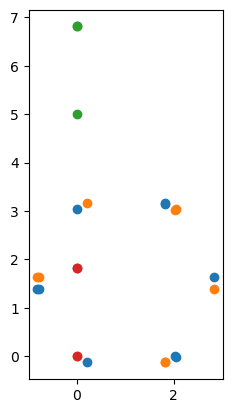

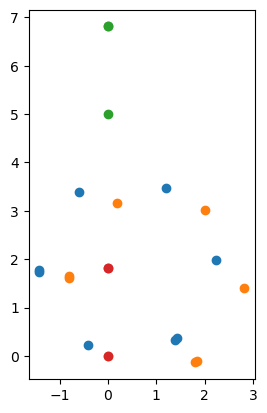

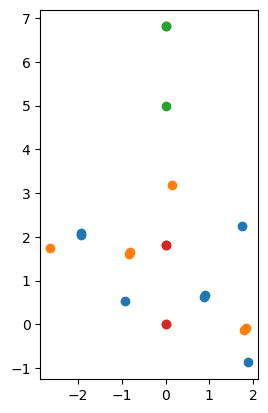

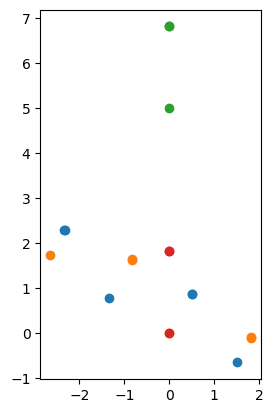

In [159]:
i = 0
j = 11
idx = i* 12 + j
print(db_local_fingerprint[idx][0])

for i in range(4):

    pos_00  = moire_grid_atoms[i][i].positions
    # pos_00  -= pos_00[0]

    print(moire_grid_fingerprint[i][i][0])
    plt.figure()

    plt.scatter(pos_00[pos_00[:,2] > pos_00[:,2].mean(),0],
                pos_00[pos_00[:,2] > pos_00[:,2].mean(),1])

    plt.scatter(pos_00[pos_00[:,2] <= pos_00[:,2].mean(),0],
                pos_00[pos_00[:,2] <= pos_00[:,2].mean(),1])

    pos_db = clean_database[idx].positions
    plt.scatter(pos_db[pos_db[:,2] > pos_db[:,2].mean(),0],
                pos_db[pos_db[:,2] > pos_db[:,2].mean(),1])
    plt.scatter(pos_db[pos_db[:,2] <= pos_db[:,2].mean(),0],
                pos_db[pos_db[:,2] <= pos_db[:,2].mean(),1])
    plt.axis('scaled')


In [11]:
db_local_fingerprint[0].size

72

0 0 [2003]
0 1 [1739]
0 2 [1448]
0 3 [1327]
0 4 [1448]
0 5 [1751]
1 0 [1739]
1 1 [1751]
1 2 [1592]
1 3 [1304]
1 4 [1435]
1 5 [1448]
2 0 [1442]
2 1 [1586]
2 2 [1442]
2 3 [1304]
2 4 [1303]
2 5 [1435]
3 0 [1423]
3 1 [1298]
3 2 [1298]
3 3 [1311]
3 4 [1304]
3 5 [1304]
4 0 [1442]
4 1 [1431]
4 2 [1299]
4 3 [1298]
4 4 [1559]
4 5 [1592]
5 0 [1751]
5 1 [1442]
5 2 [1431]
5 3 [1298]
5 4 [1586]
5 5 [1739]
6
0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


(-5.0, 30.0)

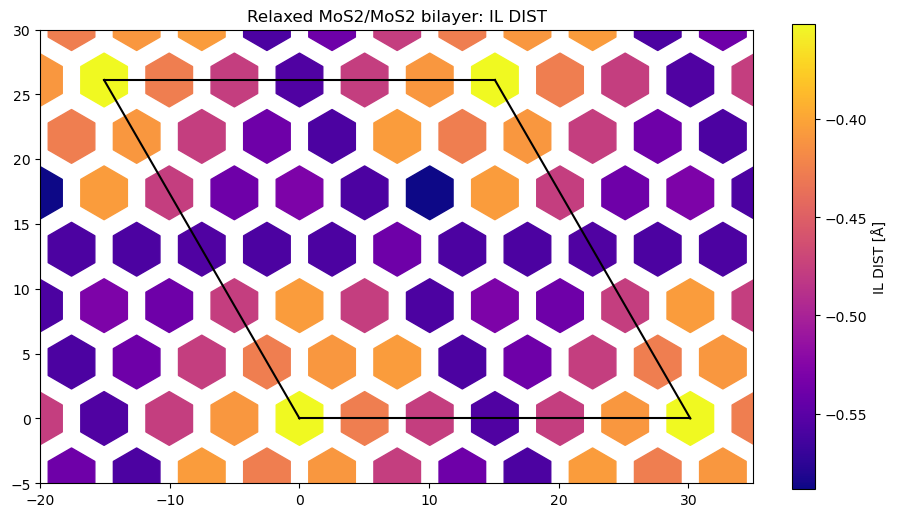

In [161]:
ref = np.array(db_local_fingerprint).reshape(-1,db_local_fingerprint[0].size)

tree = cKDTree(ref)

moire_grid_e_vals = []
for i in range(len(moire_grid_atoms)):
    moire_grid_e_vals_row = []
    for j in range(len(moire_grid_atoms[0])):
        _, ind = tree.query(np.array(moire_grid_fingerprint[i][j]).reshape(-1,db_local_fingerprint[0].size))
        print(i,j, ind)
        moire_grid_e_vals_row.append(clean_database[ind[0]].info['bandgap_rel'])
        # moire_grid_e_vals_row.append(moire_grid_atoms[i][j].info['il_dist'])
    moire_grid_e_vals.append(moire_grid_e_vals_row)

n_rows = len(moire_grid_atoms)
print(n_rows)
plt.figure(figsize=(10,10))
# plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
vmin = np.array(moire_grid_e_vals).min()
vmax = np.array(moire_grid_e_vals).max()      
offsets = (np.array([(i, j) for i in [-1, 0, 1] for j in [-1, 0, 1]]) + 1/(2*n)) @ moire.cell[:2,:2]

for i in range(n_rows):
    for j in range(n_rows):
        print(i,j)
        x0y0 = moire_grid[i][j]

        x0y0 = x0y0 + (offsets * 1.)

# [moire_grid_e_vals[i][j]]*9
        plot1 = plt.scatter(x0y0[:,0],
                    x0y0[:,1], 
                    c = [moire_grid_e_vals[i][j]]*9, s = 1500,marker = "h",
                    vmin = vmin, vmax = vmax, cmap = 'plasma')

p1 = np.array([0,0])
p2 = moire.cell[0]
p3 = moire.cell[0] + moire.cell[1]
p4 = moire.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge
plt.xlim(moire.cell[1,0]-1, moire.cell[0,0]+1)
plt.ylim(moire.cell[0,1]-5, moire.cell[1,1]+5)
plt.colorbar(plot1,fraction = 0.03,label = 'IL DIST [Å]')
plt.title("Relaxed MoS2/MoS2 bilayer: IL DIST")

# m = moire[moire.arrays['atom_types'] == atom_type].repeat([3,3,1])
# moire_shift = moire.cell[0] + moire.cell[1]
# m.positions -= moire_shift
# plot1 = plt.scatter(m.positions[:,0],m.positions[:,1],s = 500,c = e_vals * 9 , cmap = 'plasma', marker = 'H')
plt.axis('scaled')
plt.xlim(-20,35)
plt.ylim(-5,30)
# plt.savefig("relaxed_mos2_bilayer_relbands.png")


In [42]:
moire_grid

array([[[ -1.25610342,  -2.17563494],
        [ -3.76831025,   2.17563494],
        [ -6.28051709,   6.52690482],
        [ -8.79272393,  10.8781747 ],
        [-11.30493076,  15.22944458],
        [-13.8171376 ,  19.58071446],
        [-16.32934444,  23.93198434]],

       [[  3.76831025,  -2.17563494],
        [  1.25610342,   2.17563494],
        [ -1.25610342,   6.52690482],
        [ -3.76831025,  10.8781747 ],
        [ -6.28051709,  15.22944458],
        [ -8.79272393,  19.58071446],
        [-11.30493076,  23.93198434]],

       [[  8.79272393,  -2.17563494],
        [  6.28051709,   2.17563494],
        [  3.76831025,   6.52690482],
        [  1.25610342,  10.8781747 ],
        [ -1.25610342,  15.22944458],
        [ -3.76831025,  19.58071446],
        [ -6.28051709,  23.93198434]],

       [[ 13.8171376 ,  -2.17563494],
        [ 11.30493076,   2.17563494],
        [  8.79272393,   6.52690482],
        [  6.28051709,  10.8781747 ],
        [  3.76831025,  15.22944458],
      

In [43]:
n_rows

6

In [96]:

atom_type = 3
ref = np.array(db_point_fingerprint).reshape(-1,12)

tree = cKDTree(ref)
dist, ind = tree.query(np.array(moire_point_fingerprint).reshape(-1,12))

e_vals = [clean_database[idx].info['bandgap_rel'] for idx in ind]
m = moire[moire.arrays['atom_types'] == atom_type].repeat([3,3,1])
moire_shift = moire.cell[0] + moire.cell[1]
m.positions -= moire_shift
plot1 = plt.scatter(m.positions[:,0],m.positions[:,1],s = 500,c = e_vals * 9 , cmap = 'plasma', marker = 'H')
plt.axis('scaled')

# # # moire[moire.arrays['atom_types'] == 0].positions

p1 = np.array([0,0])
p2 = moire.cell[0]
p3 = moire.cell[0] + moire.cell[1]
p4 = moire.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge
plt.xlim(moire.cell[1,0]-1, moire.cell[0,0]+1)
plt.ylim(moire.cell[0,1]-5, moire.cell[1,1]+5)
plt.colorbar(plot1,fraction = 0.03,label = 'Relative Band Gap (eV)')

NameError: name 'db_point_fingerprint' is not defined

In [39]:
atom_type = 0
moire_padded = moire.repeat([3,3,1])
moire_shift = moire.cell[0] + moire.cell[1]
moire_padded.positions -= moire_shift

tree = cKDTree(moire_padded.positions[:,:2])

dist, ind = tree.query(moire[moire.arrays['atom_types'] == atom_type].positions[:,:2], k = 12)

pos_diff = moire_padded.positions[ind,:2] - moire[moire.arrays['atom_types'] == atom_type].positions[:,None,:2]
z_diff = moire_padded.positions[ind,2] - moire[moire.arrays['atom_types'] == atom_type].positions[:,None,2]

zero_shell_cart = reduce_to_shell(pos_diff,pristine_atoms.cell[:2,:2], n_shell = 1)

zero_shell_norm = np.linalg.norm(zero_shell_cart,axis = -1)

ntype_dists = np.concatenate((moire_padded.arrays['atom_types'][ind][:,:,None],zero_shell_norm[:,:,None]),axis = -1)
ntype_dists = np.take_along_axis(ntype_dists[:,:,:], np.argsort(ntype_dists[:,:,0],axis = 1)[:,:,None], axis=1)

ntype_z_dists = np.concatenate((moire_padded.arrays['atom_types'][ind][:,:,None],z_diff[:,:,None]),axis = -1)
ntype_z_dists = np.take_along_axis(ntype_z_dists[:,:,:], np.argsort(ntype_z_dists[:,:,0],axis = 1)[:,:,None], axis=1)

reduced_ntype_dists = [np.split(metal[:, 1], np.unique(metal[:, 0], return_index=True)[1][1:]) for metal in ntype_dists] 
reduced_ntype_z_dists = [np.split(metal[:, 1], np.unique(metal[:, 0], return_index=True)[1][1:]) for metal in ntype_z_dists] 

reduced_ntype_figureprint= [[[np.mean(m),np.mean(l)]for m,l in zip(metal,metal_z)] for metal, metal_z in zip(reduced_ntype_dists,reduced_ntype_z_dists)]

reduced_ntype_figureprint

[[[1.4034151618602669e-15, 0.0],
  [1.35464490182885, 1.574701677566667],
  [1.3330659998772156, -1.5567919263999999],
  [0.23990894327969764, 6.5685313359999995],
  [1.4529853085874707, 8.121885934],
  [1.4796645086066427, 4.9903566533]],
 [[1.2153931822272407e-15, 0.0],
  [1.350970521248698, 1.5724496372666668],
  [1.3358064041066615, -1.5596755365000003],
  [0.6191908226739482, 6.4874006952],
  [2.036614412934097, 8.0445942271],
  [2.0422137169447487, 4.912549498400001]],
 [[9.28271876114931e-16, 0.0],
  [1.3527500681689533, 1.5735176517333336],
  [1.3345146265551022, -1.5582719852333333],
  [0.47249480451300113, 6.526048802],
  [1.5811769091726167, 8.091215971650001],
  [1.5867995325298239, 4.95955230715]],
 [[1.8565437522298626e-15, 0.0],
  [1.3512476969552798, 1.5724594116333332],
  [1.335890499963553, -1.5595380204333333],
  [0.6191905463950005, 6.4874011938],
  [1.2600039226691622, 8.0349015616],
  [1.2844850000744246, 4.9025310148]],
 [[7.017075809301334e-16, 0.0],
  [1.346799

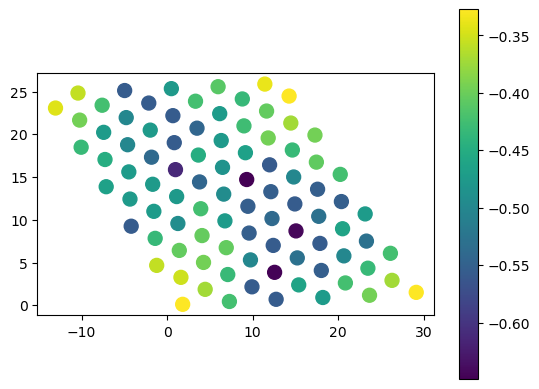

In [ ]:
tree = cKDTree(np.array(db_point_fingerprint))
dist, ind = tree.query(moire_point_fingerprint)

atom_type = 3
e_vals = [clean_database[idx].info['bandgap_rel'] for idx in ind ]
m = moire[moire.arrays['atom_types'] == atom_type]
p1 = plt.scatter(m.positions[:,0],m.positions[:,1],s = 100,c = e_vals)
plt.axis('scaled')

# moire[moire.arrays['atom_types'] == 0].positions
plt.colorbar(p1)



In [ ]:
s = clean_database[0]
s_padded = s.repeat([5,5,1])
s_shift = s.cell[0] + s.cell[1]
s_padded.positions -= s_shift

tree = cKDTree(s_padded.positions[:,:2])

dist, ind = tree.query(s[s.arrays['atom_types'] == 0].positions[:,:2], k = 12)

pos_diff = moire_padded.positions[ind] - moire[moire.arrays['atom_types'] == 0].positions[0]

# zero_shell_cart = reduce_to_shell(pos_diff,pristine_atoms.cell, n_shell = 1)

# zero_shell_norm = np.linalg.norm(zero_shell_cart,axis = -1)

# ntype_dists = np.concatenate((s_padded.arrays['atom_types'][ind][:,:,None],zero_shell_norm[:,:,None]),axis = -1)
# ntype_dists = np.take_along_axis(ntype_dists[:,:,:], np.argsort(ntype_dists[:,:,0],axis = 1)[:,:,None], axis=1)

# # ntype_dists = ntype_dists[ntype_dists[:, 0].argsort()]
# reduced_ntype_dists = [np.split(metal[:, 1], np.unique(metal[:, 0], return_index=True)[1][1:]) for metal in ntype_dists] 
# reduced_ntype_figureprint= [[np.mean(l) for l in metal] for metal in reduced_ntype_dists]
# reduced_ntype_figureprint

pos_diff

NameError: name 'clean_database' is not defined

In [ ]:
print(np.around(np.linalg.norm((moire_padded.positions[ind] - moire[moire.arrays['atom_types'] == 0].positions[0])@ np.linalg.inv(pristine_atoms.cell),axis = -1),2))
np.around(np.linalg.norm(zero_shell_fixed((moire_padded.positions[ind] - moire[moire.arrays['atom_types'] == 0].positions[0])@ np.linalg.inv(pristine_atoms.cell),2),axis = -1),4)

[0.   0.34 0.57 0.66 0.6  0.82 0.56 0.57 0.82 0.58 0.61 0.67 0.94 1.
 1.27 0.85 1.23 1.26 1.32 1.32]


array([0.    , 0.3427, 0.5653, 0.6555, 0.5984, 0.8166, 0.5588, 0.5651,
       0.822 , 0.5773, 0.6109, 0.6706, 0.9401, 0.9975, 1.1562, 0.8503,
       1.0396, 0.99  , 1.0618, 1.063 ])

(-7.861022375, 8.651074875, -4.5841770866668154, 5.952588157313627)

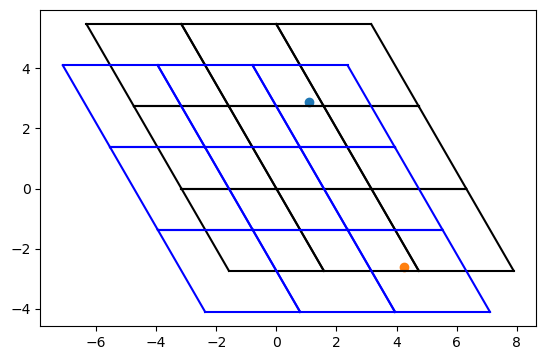

In [ ]:
x1 = [0.872,1.051] @ pristine_atoms.cell[:2,:2]
x2 = [0.872,-0.949] @ pristine_atoms.cell[:2,:2]
plt.scatter(x1[0],x1[1])
plt.scatter(x2[0],x2[1])
p1 = np.array([0,0])
p2 = pristine_atoms.cell[0]
p3 = pristine_atoms.cell[0] + pristine_atoms.cell[1]
p4 = pristine_atoms.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
for ii in [-1,0,1]:
    for jj in [-1,0,1]:
        i = ii * pristine_atoms.cell[0,0] + jj * pristine_atoms.cell[1,0]
        j = ii * pristine_atoms.cell[0,1] + jj * pristine_atoms.cell[1,1]
        plt.plot([p1[0]+i, p2[0]+i], [p1[1]+j, p2[1]+j], color='black') # Bottom edge
        plt.plot([p2[0]+i, p3[0]+i], [p2[1]+j, p3[1]+j], color='black') # Right edge
        plt.plot([p3[0]+i, p4[0]+i], [p3[1]+j, p4[1]+j], color='black') # Top edge
        plt.plot([p4[0]+i, p1[0]+i], [p4[1]+j, p1[1]+j], color='black') # Left edge

for ii in [-1.5,-.5,.5]:
    for jj in [-1.5,-.5,.5]:
        i = ii * pristine_atoms.cell[0,0] + jj * pristine_atoms.cell[1,0]
        j = ii * pristine_atoms.cell[0,1] + jj * pristine_atoms.cell[1,1]
        plt.plot([p1[0]+i, p2[0]+i], [p1[1]+j, p2[1]+j], color='blue') # Bottom edge
        plt.plot([p2[0]+i, p3[0]+i], [p2[1]+j, p3[1]+j], color='blue') # Right edge
        plt.plot([p3[0]+i, p4[0]+i], [p3[1]+j, p4[1]+j], color='blue') # Top edge
        plt.plot([p4[0]+i, p1[0]+i], [p4[1]+j, p1[1]+j], color='blue') # Left edge
# np.linalg.norm([0.872,1.051] @ pristine_atoms.cell[:2,:2]), np.linalg.norm([0.872,-0.949] @ pristine_atoms.cell[:2,:2])
plt.axis('scaled')

In [ ]:
pristine_atoms.cell[:2,:2].T

array([[ 3.16021   , -1.580105  ],
       [ 0.        ,  2.73682214]])

In [ ]:
def zero_shell_fixed(x, n_shell:int = 1, eps=1e-6):
    '''
    Fits crystal coordinates between (-0.5 - n_shell + 1) and (.5 + n_shell + 1)
        
    Parameters
    ----------
    x: float
        Crystal coordinate
    n_shell: int
        Number of shells
    eps: float
        Error term
    '''
    y = x.copy()
    y[np.logical_and(y>( - n_shell /2 ),
                     y<(- n_shell / 2 + eps))] = - n_shell / 2
    y = (y + n_shell/2) % n_shell - n_shell/2
    y[y>(n_shell / 2 - eps)] = n_shell / 2
    return y

x = np.array([-0.41,-0.49])
zero_shell_fixed(x)

array([-0.41, -0.49])

In [ ]:
(unit_range_fixed((moire_padded.positions[ind] - moire[moire.arrays['atom_types'] == 0].positions[0]) @ np.linalg.inv(pristine_atoms.cell)) @ pristine_atoms.cell)[:,2]

array([ 0.        ,  6.56853134,  5.00079449,  8.1322181 ,  1.58861617,
        1.56774429,  1.56774457, 18.43632138, 18.43632104,  4.97991881,
       18.45698181,  8.11155377,  5.0007942 ,  8.13221776,  6.54728853,
        6.56853153,  6.52749496,  0.02123972,  0.04009377,  0.        ])

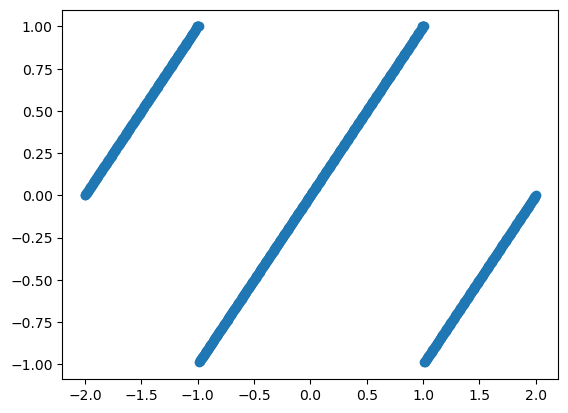

In [ ]:
def zero_shell_fixed(x, n_shell:int = 1, eps=1e-6):
    '''
    Fits crystal coordinates between (-0.5 - n_shell + 1) and (.5 + n_shell + 1)
        
    Parameters
    ----------
    x: float
        Crystal coordinate
    n_shell: int
        Number of shells
    eps: float
        Error term
    '''
    y = x.copy()
    y[np.logical_and(y>( - n_shell /2 ),
                     y<(- n_shell / 2 + eps))] = - n_shell / 2
    y = (y + n_shell/2 - eps) % n_shell - n_shell/2 + eps
    y[y>(n_shell / 2 - eps)] = n_shell / 2
    return y

x = np.linspace(-2,2,1000)
# x = np.array([0.999999999])
y = zero_shell_fixed(x,n_shell = 2, eps=1e-2)

plt.scatter(x,y)


In [ ]:
[j.positions[j.arrays['atom_types']==0] for l in moire_grid_atoms for j in l]

[array([[-0.80702994,  1.63772538, -3.28427668]]),
 array([[-0.60674335,  4.79206686, -3.24418291]]),
 array([[-3.25188096,  6.53602842, -3.19526239],
        [-3.08654852,  9.67814331, -3.14086763]]),
 array([[-5.76377047, 11.39480224, -3.10450413]]),
 array([[-5.62581381, 14.52450617, -3.09206888],
        [-8.31134559, 16.23077383, -3.11338006]]),
 array([[-8.1557064 , 19.36354716, -3.14963658]]),
 array([[-10.8134375 ,  21.08908229,  -3.21050702]]),
 array([[-10.61988063,  24.23707719,  -3.24418274],
        [-13.2514768 ,  25.98770112,  -3.28427635]]),
 array([[ 4.65514597,  1.28522651, -3.24324318],
        [ 2.02645509,  3.03750187, -3.26303695]]),
 array([[ 4.84929856,  4.44834703, -3.20867693],
        [ 2.21627871,  6.19843938, -3.21050709]]),
 array([[-0.42689274,  7.94530096, -3.18296637]]),
 array([[-0.27214736, 11.09811433, -3.12398003],
        [-2.9424384 , 12.81754089, -3.09863506]]),
 array([[-2.80723333, 15.95685625, -3.08091477]]),
 array([[-5.4840431 , 17.65625062,

In [ ]:
def moire_grid_fingerprint(moire_grid_atoms):
    moire_grid_col_matrix = []
    for i in range(len(moire_grid_atoms)):
        moire_grid_col_matrix_row = []
        for j in range(len(moire_grid_atoms)):
            s = moire_grid_atoms[i][j].copy()
            
            s.cell = pristine_atoms.cell
            # test.positions,test.arrays['atom_types']
            idx_zero = np.argmin(np.linalg.norm(s.positions[s.arrays['atom_types'] == 0],axis = -1))
            pos_zero = s.positions[s.arrays['atom_types'] == 0][idx_zero]
            s.positions -= pos_zero
            unique_atom_types = np.unique(s.arrays['atom_types'])
            scaled_positions = s.get_scaled_positions()
            reduced_positions = np.zeros((len(unique_atom_types), 3))

            for u in unique_atom_types:
                scaled_positions_of_type = scaled_positions[s.arrays['atom_types'] == u]
                mean_scaled_positions = (((scaled_positions_of_type + 0.5) % 1) - 0.5).mean(axis=0)
                reduced_positions[u] = mean_scaled_positions 

            col_matrix = np.linalg.norm(reduced_positions[:,None] - reduced_positions[None,:],axis = -1)
            moire_grid_col_matrix_row.append({"reduced_positions":reduced_positions, 'col_matrix':col_matrix})
        moire_grid_col_matrix.append(moire_grid_col_matrix_row)
    return moire_grid_col_matrix

def moire_grid_2Dfingerprint(moire_grid_atoms):
    moire_grid_col_matrix = []
    for i in range(len(moire_grid_atoms)):
        moire_grid_col_matrix_row = []
        for j in range(len(moire_grid_atoms)):
            s = moire_grid_atoms[i][j].copy()
            
            s.cell = pristine_atoms.cell
            # test.positions,test.arrays['atom_types']
            idx_zero = np.argmin(np.linalg.norm(s.positions[s.arrays['atom_types'] == 0],axis = -1))
            pos_zero = s.positions[s.arrays['atom_types'] == 0][idx_zero]
            s.positions -= pos_zero
            unique_atom_types = np.unique(s.arrays['atom_types'])
            scaled_positions = s.get_scaled_positions()
            reduced_positions = np.zeros((len(unique_atom_types), 3))

            for u in unique_atom_types:
                scaled_positions_of_type = scaled_positions[s.arrays['atom_types'] == u]
                mean_scaled_positions = (((scaled_positions_of_type + 0.5) % 1) - 0.5).mean(axis=0)
                reduced_positions[u] = mean_scaled_positions 

            col_matrix = np.linalg.norm(reduced_positions[:,None,:2] - reduced_positions[None,:,:2],axis = -1)
            moire_grid_col_matrix_row.append({"reduced_positions":reduced_positions,
                                              'col_matrix':col_matrix,
                                              'il_dist': s.info['il_dist']})
        moire_grid_col_matrix.append(moire_grid_col_matrix_row)
    return moire_grid_col_matrix

moire_grid_fingerprint = moire_grid_fingerprint(moire_grid_atoms)
moire_grid_2Dfingerprint = moire_grid_2Dfingerprint(moire_grid_atoms)


def match_fingerprints(db_fingerprint, moire_grid_fingerprint, value = 'e_value'):
    moire_grid_value = []
    moire_grid_match_idx = []

    dp_fp_scaled_flat = np.array([f['fp_scaled'].flatten() for f in db_fingerprint])
    tree = cKDTree(dp_fp_scaled_flat)

    for i in range(len(moire_grid_fingerprint)):
        moire_grid_value_row = []
        moire_grid_match_idx_row = []
        for j in range(len(moire_grid_fingerprint)):
            grid_matrix = moire_grid_fingerprint[i][j]['col_matrix']
            distance, match_idx = tree.query(grid_matrix.flatten(), k = 1)

            match_value = db_fingerprint[match_idx][value]
            
            moire_grid_value_row.append(match_value)
            moire_grid_match_idx_row.append(match_idx)
        moire_grid_value.append(moire_grid_value_row)
        moire_grid_match_idx.append(moire_grid_match_idx_row)

    return moire_grid_match_idx, moire_grid_value

def match_2Dfingerprints(db_fingerprint, moire_grid_fingerprint, value = 'e_value'):
    moire_grid_value = []
    moire_grid_match_idx = []

    unique_il_dist = np.unique([f['il_dist'] for f in db_fingerprint])

    for i in range(len(moire_grid_fingerprint)):
        moire_grid_value_row = []
        moire_grid_match_idx_row = []
        for j in range(len(moire_grid_fingerprint)):
            
            z_match = unique_il_dist[np.argmin(np.abs(unique_il_dist- moire_grid_fingerprint[i][j]['il_dist']))]
            
            dp_fp_scaled_flat = np.array([f['fp_scaled'].flatten() for f in db_fingerprint if f['il_dist'] == z_match])

            xy_tree = cKDTree(dp_fp_scaled_flat)
            grid_matrix = moire_grid_fingerprint[i][j]['col_matrix']
            distance, match_idx = xy_tree.query(grid_matrix.flatten(), k = 1)

            match_value = db_fingerprint[match_idx][value]
            
            moire_grid_value_row.append(match_value)
            moire_grid_match_idx_row.append(match_idx)
        moire_grid_value.append(moire_grid_value_row)
        moire_grid_match_idx.append(moire_grid_match_idx_row)

    return moire_grid_match_idx, moire_grid_value

def match_meanZ(db_fingerprint,moire_grid_fingerprint, value = 'e_value'):
    moire_grid_value = []
    moire_grid_match_idx = []

    unique_il_dist = np.unique([f['il_dist'] for f in db_fingerprint])

    for i in range(len(moire_grid_fingerprint)):
        moire_grid_value_row = []
        moire_grid_match_idx_row = []
        for j in range(len(moire_grid_fingerprint)):
            
            z_match = unique_il_dist[np.argmin(np.abs(unique_il_dist- moire_grid_fingerprint[i][j]['il_dist']))]
            # print(z_match)
            evalue = np.array([f['e_value'] for f in db_fingerprint if np.abs(f['il_dist']- z_match) < 1e-5]).mean()
            match_value = evalue

        #     xy_tree = cKDTree(dp_fp_scaled_flat)
        #     grid_matrix = moire_grid_fingerprint[i][j]['col_matrix']
        #     distance, match_idx = xy_tree.query(grid_matrix.flatten(), k = 1)

        #     match_value = db_fingerprint[match_idx][value]
            
            moire_grid_value_row.append(match_value)
        #     moire_grid_match_idx_row.append(match_idx)
        moire_grid_value.append(moire_grid_value_row)
        # moire_grid_match_idx.append(moire_grid_match_idx_row)

    return moire_grid_match_idx, moire_grid_value


# moire_grid_match_idx, moire_grid_value =  match_fingerprints(db_fingerprint, moire_grid_fingerprint)
# moire_grid_match_idx_2D, moire_grid_value_2D =  match_2Dfingerprints(db_2Dfingerprint, moire_grid_2Dfingerprint)
moire_grid_match_idx_z, moire_grid_value_z =  match_meanZ(db_2Dfingerprint, moire_grid_2Dfingerprint)

In [ ]:
np.array(moire_grid_value_z).min()

-0.6040430555555555

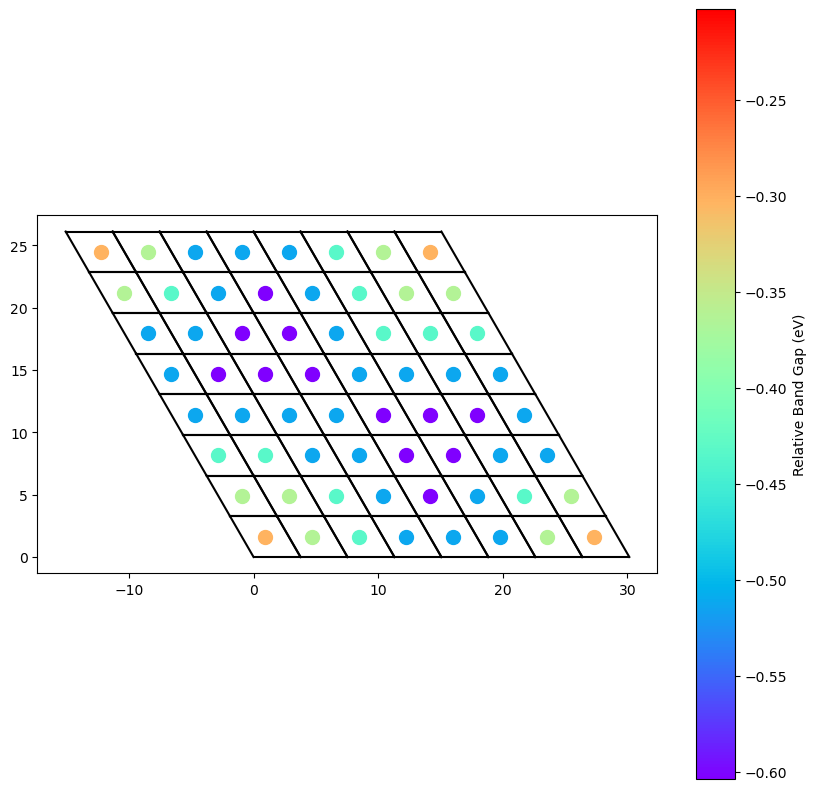

In [ ]:
n_rows = len(moire_grid_atoms) + 1
plt.figure(figsize=(10,10))
# plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
vmin = np.array(moire_grid_value_z).min()
vmax = np.array(moire_grid_value_z).max() + 0.1
for i in range(n_rows - 1):
    for j in range(n_rows - 1):
        x0y0 = np.array([moire_grid[0][i][j] + 1/(2*n),
                         moire_grid[1][i][j] + 1/(2*n)])
        x0y0 = x0y0 @ moire.cell[:2,:2]
        
        plt.scatter(x0y0[0],
                    x0y0[1], 
                    c = moire_grid_value_z[i][j], s = 100,
                    vmin = vmin, vmax = vmax, cmap = 'rainbow')
        
        # plt.scatter(x0y0[0],
        #             x0y0[1], 
        #             c = moire_grid_atoms[i][j].info['il_dist'], s = 100,vmin = 3.0, vmax = 3.4, cmap = 'rainbow')

for i in range(n_rows-1):
    for j in range(n_rows-1):
        p1 = np.array([moire_grid[0][i, j], moire_grid[1][i, j]]) @ moire.cell[:2,:2]
        p2 = np.array([moire_grid[0][i+1, j], moire_grid[1][i+1, j] ]) @ moire.cell[:2,:2]
        p3 = np.array([moire_grid[0][i+1, j+1], moire_grid[1][i+1, j+1]]) @ moire.cell[:2,:2]
        p4 = np.array([moire_grid[0][i, j+1], moire_grid[1][i, j+1]]) @ moire.cell[:2,:2]
        # print(x0,y0)
        # Draw lines around each grid cell
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black',zorder = 0) # Bottom edge
        plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black',zorder = 0) # Right edge
        plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black',zorder = 0) # Top edge
        plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black',zorder = 0) # Left edge

    plt.axis('scaled')
    
plt.colorbar(label = 'Relative Band Gap (eV)')

# plt.figure(figsize=(10,10))
# # plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
# for i in range(n_rows - 1):
#     for j in range(n_rows - 1):
#         x0y0 = np.array([moire_grid[0][i][j] + 1/(2*n),
#                          moire_grid[1][i][j] + 1/(2*n)])
#         x0y0 = x0y0 @ moire.cell[:2,:2]
        
#         plt.scatter(x0y0[0],
#                     x0y0[1], 
#                     c = moire_grid_atoms[i][j].info['il_dist'], s = 100,vmin = 3.0, vmax = 3.4, cmap = 'rainbow')

# for i in range(n_rows-1):
#     for j in range(n_rows-1):
#         p1 = np.array([moire_grid[0][i, j], moire_grid[1][i, j]]) @ moire.cell[:2,:2]
#         p2 = np.array([moire_grid[0][i+1, j], moire_grid[1][i+1, j] ]) @ moire.cell[:2,:2]
#         p3 = np.array([moire_grid[0][i+1, j+1], moire_grid[1][i+1, j+1]]) @ moire.cell[:2,:2]
#         p4 = np.array([moire_grid[0][i, j+1], moire_grid[1][i, j+1]]) @ moire.cell[:2,:2]
#         # print(x0,y0)
#         # Draw lines around each grid cell
#         plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black',zorder = 0) # Bottom edge
#         plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black',zorder = 0) # Right edge
#         plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black',zorder = 0) # Top edge
#         plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black',zorder = 0) # Left edge

#     plt.axis('scaled')
# plt.colorbar()


In [ ]:
unique_il_dist = np.unique([f['il_dist'] for f in db_fingerprint])
for z in [3.0,3.1,3.2,3.3]:
    vals_z  = np.array([f['e_value'] for f in db_fingerprint if np.abs(f['il_dist'] - z) < 0.001])
    mean_z = vals_z.mean()
    width_z = vals_z.max()- vals_z.min()
    print(mean_z,width_z)


-0.6040430555555555 0.2259000000000002
-0.5131604166666666 0.17499999999999982
-0.43375347222222216 0.13560000000000016
-0.36414513888888883 0.10510000000000042


In [ ]:
t1 = moire_grid_fingerprint[0][0]['col_matrix']
t2 = db_fingerprint[0]['fp_scaled']

dp_fp_scaled_flat = np.array([f['fp_scaled'].flatten() for f in db_fingerprint])

tree = cKDTree(dp_fp_scaled_flat)
distance,index = tree.query(t1.flatten(), k = 1)
print(index)
dp_fp_scaled_flat[index].reshape(6,6)
db_test = np.around(db_fingerprint[index]['scaled_positions']@ pristine_atoms.cell,4)
moire_test = np.around(moire_grid_fingerprint[0][0]['reduced_positions']@ pristine_atoms.cell,4)

1649


In [ ]:
clean_database[ii]

NameError: name 'ii' is not defined

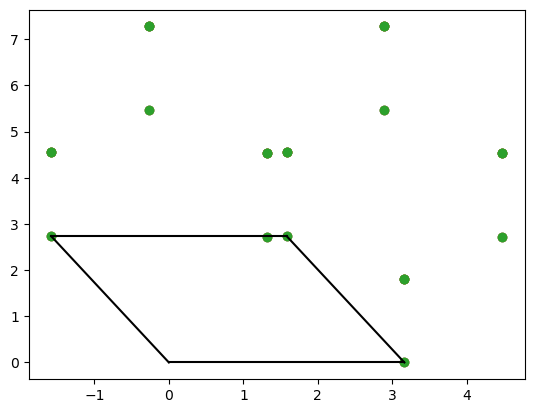

In [ ]:
for i in [-1,0,1]:
    ii = index + 0
    plt.scatter(clean_database[ii].repeat((2,2,1)).positions[3:,0],clean_database[ii].repeat((2,2,1)).positions[3:,1], label = i)

p1 = np.array([0,0])
p2 = pristine_atoms.cell[0]
p3 = pristine_atoms.cell[0] + pristine_atoms.cell[1]
p4 = pristine_atoms.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

(array([[ 0.    ,  0.    ,  0.    ],
        [ 1.5801, -0.9205,  1.5717],
        [ 1.5801, -0.9205, -1.5717],
        [-0.2693,  0.8958,  6.3434],
        [ 1.3108, -0.0247,  7.9152],
        [ 1.3108, -0.0247,  4.7717]]),
 array([[-0.    ,  0.    ,  0.    ],
        [ 1.5801, -0.9119,  1.5859],
        [ 1.5801, -0.9119, -1.5859],
        [-0.0608,  0.2456,  6.147 ],
        [ 1.6148, -0.6613,  7.7329],
        [ 1.6148, -0.6613,  4.5611]]))

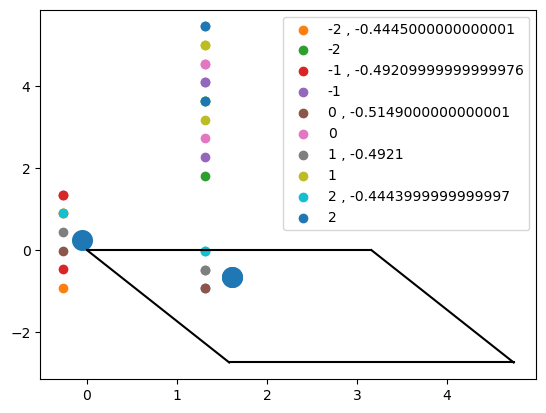

In [ ]:
plt.scatter(moire_test[3:,0],moire_test[3:,1], s = 200)
for i in [-2,-1,0,1,2]:
    ii = index + i
    db_test = np.around(db_fingerprint[ii]['scaled_positions']@ pristine_atoms.cell,4)

    plt.scatter(db_test[3:,0],db_test[3:,1], label = f'{i} , {db_fingerprint[ii]["e_value"]}')
    plt.scatter(clean_database[ii].positions[3:,0],clean_database[ii].positions[3:,1], label = i)

p1 = np.array([0,0])
p2 = pristine_atoms.cell[0]
p3 = pristine_atoms.cell[0] - pristine_atoms.cell[1]
p4 = -pristine_atoms.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

plt.legend()
db_test, moire_test

In [ ]:
ss_scaled_positions = clean_database[0].get_scaled_positions()
ss_scaled_positions = (((ss_scaled_positions + 0.5) % 1) - 0.5)
ss_scaled_positions
np.linalg.norm(ss_scaled_positions[:,None] - ss_scaled_positions[None,:],axis = -1)

array([[0.        , 0.47897139, 0.47897139, 0.2621723 , 0.58254109,
        0.50689415],
       [0.47897139, 0.        , 0.1571723 , 0.50689415, 0.2621723 ,
        0.105     ],
       [0.47897139, 0.1571723 , 0.        , 0.58254109, 0.4193446 ,
        0.2621723 ],
       [0.2621723 , 0.50689415, 0.58254109, 0.        , 0.47897139,
        0.47897139],
       [0.58254109, 0.2621723 , 0.4193446 , 0.47897139, 0.        ,
        0.1571723 ],
       [0.50689415, 0.105     , 0.2621723 , 0.47897139, 0.1571723 ,
        0.        ]])

In [ ]:
np.linalg.norm(db_fingerprint[0]['fp_scaled'] - col_matrix)/36

0.006919953795149488

In [ ]:
import pymoire as pm

p = pm.materials.get_materials_db_path()
pristine_atoms = pm.read_monolayer(p/'MoS2.cif')
pristine_cell = pristine_atoms.cell
pristine_cell[2,2] = 20

def prepare_database(structures,pristine_cell):
    clean_database = []
    unique_atom_types = np.unique(structures[0].arrays['atom_types'])
    for ss in structures:
        s = ss.copy()
        s.positions -= s.positions[np.where(s.arrays['atom_types'] == 0)[0][0]]
        s.set_cell(pristine_cell)
        scaled_positions = s.get_scaled_positions()

        for u in unique_atom_types:
            scaled_positions_of_type = scaled_positions[s.arrays['atom_types'] == u]
            mean_scaled_positions = (((scaled_positions_of_type + 0.5) % 1) - 0.5).mean(axis=0)
            # print(u, mean_scaled_positions)

            scaled_positions[s.arrays['atom_types'] == u] = mean_scaled_positions 

        s.set_scaled_positions(scaled_positions)

        clean_atoms = Atoms()
        clean_atoms.set_cell(s.get_cell())
        clean_atoms.set_pbc(s.get_pbc())
        clean_atoms.info = s.info

        print(clean_atoms)
        for u in unique_atom_types:
           
            clean_atoms += s[s.arrays['atom_types'] == u][0]
            print(s[s.arrays['atom_types'] == u][0])
        clean_database.append(clean_atoms)

    return clean_database

clean_database = prepare_database(structures[:1],pristine_cell)

Atoms(symbols='', pbc=[True, True, False], cell=[[3.16021, 0.0, 0.0], [-1.5801049999999994, 2.7368221412936213, 0.0], [0.0, 0.0, 20.0]])
Atom('Mo', [-0.0035847950000003686, -0.006183935646810494, 0.0], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 1.5717229799999988], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, -1.571722980000001], index=0)
Atom('Mo', [-0.0035847950000003686, -0.006183935646810494, 5.243445959999999], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 6.81516894], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 3.6717229800000006], index=0)


In [ ]:
write("moire_relax.cif", moire, format="cif")

In [ ]:
clean_database[1].get_scaled_positions() , clean_database[0].cell

(array([[ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615],
        [ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615]]),
 Cell([[3.16021, 0.0, 0.0], [-1.5801049999999994, 2.7368221412936213, 0.0], [0.0, 0.0, 20.0]]))

In [ ]:
# # [item for row in moire_grid_atoms for item in row]

# moire_grid_atoms[4][4].set_cell(pristine_cell)

# # moire_grid_atoms[0][0].cell

# structures_120 = structures.copy()
# for s in structures_120:
#     s.set_cell(pristine_cell)

structures[50].positions -= structures[50].positions[structures[50].arrays['atom_types']==0]
structures[50].cell = pristine_cell


In [ ]:
write('moire_grid_atoms.xyz',[item for row in moire_grid_atoms for item in row], format="extxyz")
write('structures120.xyz',structures_120, format="extxyz")
write('test.cif',structures[50], format="cif")
write('test1.cif',structures_120[50], format="cif")

write('moire_grid_atoms_4_4.cif', moire_grid_atoms[4][4], format="cif")

/pscratch/sd/j/jdgeorga/ml_iaps/venv_ml_iaps/lib/python3.9/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [ ]:
def find_closest_match(grid_cell, database):
    """
    Find the closest matching atomic configuration in the database for the given grid cell.
    
    Parameters:
    - grid_cell: The atomic positions in the current grid cell.
    - database: A data structure holding atomic configurations and their energy values.
    
    Returns:
    - The energy value of the closest matching configuration.
    """
    # Logic to compare `grid_cell` with entries in `database` and find the closest match
    # This is highly dependent on the structure of your database and the data format
    closest_match_energy = ...  # Placeholder for actual logic
    return closest_match_energy

In [ ]:
def assign_energy_values(grid, database):
    """
    Assign energy values to each grid cell based on the closest match in the database.
    
    Parameters:
    - grid: The 2D array of grid points.
    - database: The database of atomic configurations and energy values.
    
    Returns:
    - A 2D array of energy values for each grid cell.
    """
    energy_grid = np.zeros_like(grid[0])  # Assuming grid[0] and grid[1] have the same shape
    for i in range(grid[0].shape[0]):
        for j in range(grid[0].shape[1]):
            grid_cell = ...  # Extract atomic positions for the grid cell at (i, j)
            energy_grid[i, j] = find_closest_match(grid_cell, database)
    return energy_grid

In [ ]:
from numpy.fft import fft2

def apply_fourier_transform(energy_grid):
    """
    Apply a Fourier transform to the grid of energy values.
    
    Parameters:
    - energy_grid: A 2D array of energy values for each grid cell.
    
    Returns:
    - The Fourier transform of the energy grid.
    """
    fourier_transform = fft2(energy_grid)
    return fourier_transform